In [13]:
# TensorBoard(save_dir="my_logs")
import os
import json
import torch
import torchvision
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode

class MyDataset(Dataset):
    
    def __init__(self, annotation_file, data_dir):
        super(MyDataset, self).__init__()
        self.data_dir = data_dir
        self.annotations = self._load_annotations(annotation_file)
        self.image_names = list(self.annotations.keys())
        self.image_list = os.listdir(self.data_dir)
        
        self.transform = transforms.Compose([
                                transforms.RandomCrop((256,256),pad_if_needed=True),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def _load_annotations(self, annotation_file):
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)
        return annotations

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.data_dir, img_name)
        label = self.annotations[img_name] - 1  # Convert 1-indexed to 0-indexed

        img = torchvision.io.read_image(os.path.join(self.data_dir, self.image_list[idx]), ImageReadMode.RGB)
        img = img.float() / 255.0  # Normalize pixel values to be between 0 and 1
        img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.image_names)

# Example usage
train_dataset = MyDataset("train_annos.json", "cars_train/")
split = int(len(train_dataset) * 0.8)
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [split, len(train_dataset) - split])
test_dataset = MyDataset(annotation_file="test_annos.json", data_dir="cars_test/")

train_loader = DataLoader(train_dataset, batch_size=1)
val_loader = DataLoader(validation_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)


class LitNetwork(pl.LightningModule):
    def __init__(self):
        super(LitNetwork, self).__init__()

        # Load the pretrained ResNet18 model
        ref_model = torchvision.models.resnet18(pretrained=True)

        # Extract the layers from the pretrained model
        self.conv1 = ref_model.conv1
        self.bn1 = ref_model.bn1
        self.relu = ref_model.relu
        self.maxpool = ref_model.maxpool
        self.layer1 = ref_model.layer1
        self.layer2 = ref_model.layer2
        self.layer3 = ref_model.layer3
        self.layer4 = ref_model.layer4
        self.avgpool = ref_model.avgpool

        # Define your own fully connected layer for the new classification task
        self.fc = nn.Linear(512, 196)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.val_acc = torchmetrics.Accuracy("multiclass", num_classes=196, average='micro')
        self.test_acc = torchmetrics.Accuracy("multiclass", num_classes=196, average='micro')

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outs = self.forward(images)
        loss = self.loss_func(outs, labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outs = self.forward(images)
        self.val_acc(outs, labels)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True, sync_dist=True)
        return None

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outs = self.forward(images)
        self.test_acc(outs, labels)
        self.log("test_acc", self.test_acc, on_step=False, on_epoch=True, sync_dist=True)
        return None


model = LitNetwork()
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_acc', save_top_k=1, mode='max')
logger = pl_loggers.TensorBoardLogger(save_dir="my_logs")

device = "cpu"  # Use 'cuda' for GPU
trainer = pl.Trainer(max_epochs=10, accelerator=device, callbacks=[checkpoint], logger=logger)
trainer.fit(model, train_loader, val_loader)

trainer.test(ckpt_path="best", dataloaders=test_loader)


C:\Users\hadi\anaconda3\envs\compvis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hadi\anaconda3\envs\compvis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name      | Type               | Params
--------------------------------------------------
0  | conv1     | Conv2d             | 9.4 K 
1  | bn1       | BatchNorm2d        | 128   
2  | relu    

Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\hadi\anaconda3\envs\compvis\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\hadi\anaconda3\envs\compvis\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

C:\Users\hadi\anaconda3\envs\compvis\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Restoring states from the checkpoint path at my_logs\lightning_logs\version_9\checkpoints\epoch=0-step=6515.ckpt
Loaded model weights from the checkpoint at my_logs\lightning_logs\version_9\checkpoints\epoch=0-step=6515.ckpt
C:\Users\hadi\anaconda3\envs\compvis\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc           0.0039796046912670135
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.0039796046912670135}]

In [8]:
# CSV(save_dir="my_logs", name="my_csv_logs")
import os
import json
import torch
import torchvision
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode

class MyDataset(Dataset):
    
    def __init__(self, annotation_file, data_dir):
        super(MyDataset, self).__init__()
        self.data_dir = data_dir
        self.annotations = self._load_annotations(annotation_file)
        self.image_names = list(self.annotations.keys())
        self.image_list = os.listdir(self.data_dir)
        
        self.transform = transforms.Compose([
                                transforms.RandomCrop((256,256),pad_if_needed=True),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def _load_annotations(self, annotation_file):
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)
        return annotations

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.data_dir, img_name)
        label = self.annotations[img_name] - 1  # Convert 1-indexed to 0-indexed

        img = torchvision.io.read_image(os.path.join(self.data_dir, self.image_list[idx]), ImageReadMode.RGB)
        img = img.float() / 255.0  # Normalize pixel values to be between 0 and 1
        img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.image_names)

# Example usage
train_dataset = MyDataset("train_annos.json", "cars_train/")
split = int(len(train_dataset) * 0.8)
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [split, len(train_dataset) - split])
test_dataset = MyDataset(annotation_file="test_annos.json", data_dir="cars_test/")

train_loader = DataLoader(train_dataset, batch_size=1)
val_loader = DataLoader(validation_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)


class LitNetwork(pl.LightningModule):
    def __init__(self):
        super(LitNetwork, self).__init__()

        # Load the pretrained ResNet18 model
        ref_model = torchvision.models.resnet18(weights=True)

        # Extract the layers from the pretrained model
        self.conv1 = ref_model.conv1
        self.bn1 = ref_model.bn1
        self.relu = ref_model.relu
        self.maxpool = ref_model.maxpool
        self.layer1 = ref_model.layer1
        self.layer2 = ref_model.layer2
        self.layer3 = ref_model.layer3
        self.layer4 = ref_model.layer4
        self.avgpool = ref_model.avgpool

        # Define your own fully connected layer for the new classification task
        self.fc = nn.Linear(512, 196)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.val_acc = torchmetrics.Accuracy("multiclass", num_classes=196, average='micro')
        self.test_acc = torchmetrics.Accuracy("multiclass", num_classes=196, average='micro')

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outs = self.forward(images)
        loss = self.loss_func(outs, labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outs = self.forward(images)
        self.val_acc(outs, labels)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True, sync_dist=True)
        return None

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outs = self.forward(images)
        self.test_acc(outs, labels)
        self.log("test_acc", self.test_acc, on_step=False, on_epoch=True, sync_dist=True)
        return None


model = LitNetwork()
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_acc', save_top_k=1, mode='max')
# Add CSVLogger to log metrics to a CSV file
logger = pl_loggers.CSVLogger(save_dir="my_logs", name="my_csv_logs")


device = "cpu"  # Use 'cuda' for GPU
trainer = pl.Trainer(max_epochs=10, accelerator=device, callbacks=[checkpoint], logger=logger)
trainer.fit(model, train_loader, val_loader)

trainer.test(ckpt_path="best", dataloaders=test_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: my_logs\my_csv_logs

   | Name      | Type               | Params
--------------------------------------------------
0  | conv1     | Conv2d             | 9.4 K 
1  | bn1       | BatchNorm2d        | 128   
2  | relu      | ReLU               | 0     
3  | maxpool   | MaxPool2d          | 0     
4  | layer1    | Sequential         | 147 K 
5  | layer2    | Sequential         | 525 K 
6  | layer3    | Sequential         | 2.1 M 
7  | layer4    | Sequential         | 8.4 M 
8  | avgpool   | AdaptiveAvgPool2d  | 0     
9  | fc        | Linear             | 100 K 
10 | loss_func | CrossEntropyLoss   | 0     
11 | val_acc   | MulticlassAccuracy | 0     
12 | test_acc  | MulticlassAccuracy | 0     
--------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total par

Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\hadi\anaconda3\envs\compvis\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\hadi\anaconda3\envs\compvis\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

C:\Users\hadi\anaconda3\envs\compvis\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Restoring states from the checkpoint path at my_logs\my_csv_logs\version_0\checkpoints\epoch=0-step=6515.ckpt
Loaded model weights from the checkpoint at my_logs\my_csv_logs\version_0\checkpoints\epoch=0-step=6515.ckpt
C:\Users\hadi\anaconda3\envs\compvis\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc           0.004974505864083767
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.004974505864083767}]

    val_acc  step  epoch  train_loss  test_acc
0  0.005525  6514      0         NaN       NaN
1       NaN  6514      0     5.50427       NaN
2       NaN  6526      1         NaN  0.004975


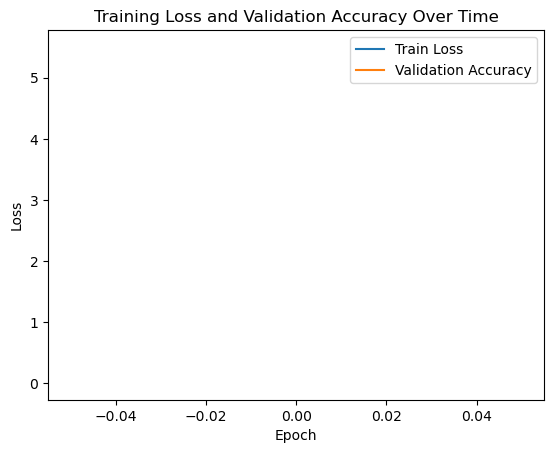

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
log_data = pd.read_csv("my_logs/my_csv_logs/version_0/metrics.csv")
print(log_data)

# Plot the training loss
plt.plot(log_data['epoch'], log_data['train_loss'], label='Train Loss')
plt.plot(log_data['epoch'], log_data['val_acc'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Accuracy Over Time')
plt.show()


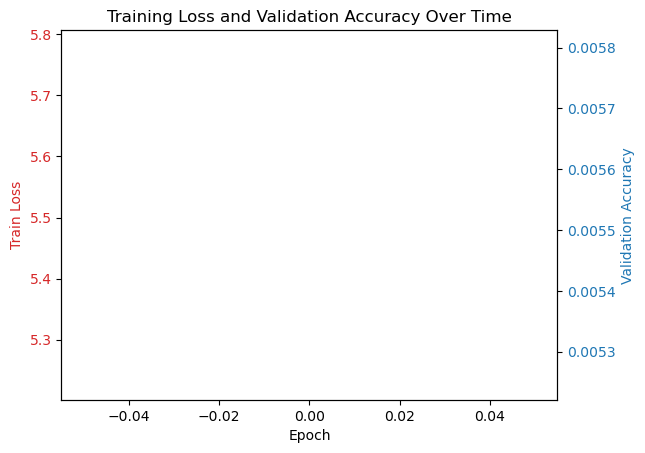

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
log_data = pd.read_csv("my_logs/my_csv_logs/version_0/metrics.csv")

# Create subplots with shared x-axis
fig, ax1 = plt.subplots()

# Plot training loss on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(log_data['epoch'], log_data['train_loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin Axes sharing the xaxis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.plot(log_data['epoch'], log_data['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Loss and Validation Accuracy Over Time')
plt.show()


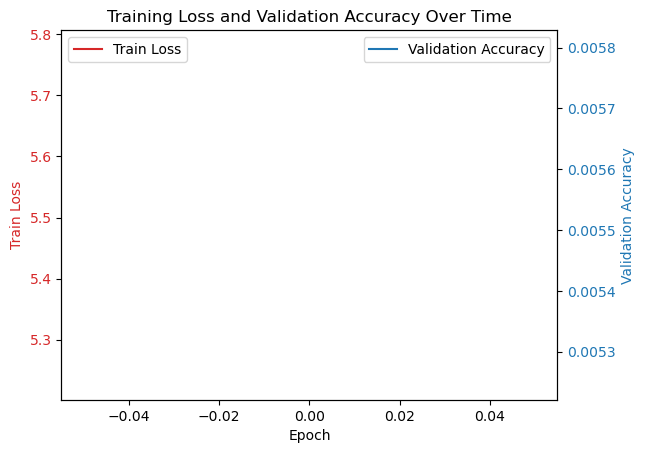

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
log_data = pd.read_csv("my_logs/my_csv_logs/version_0/metrics.csv")

# Create subplots
fig, ax1 = plt.subplots()

# Plot training loss
ax1.plot(log_data['epoch'], log_data['train_loss'], label='Train Loss', color='tab:red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')

# Create a second y-axis to plot validation accuracy
ax2 = ax1.twinx()
ax2.plot(log_data['epoch'], log_data['val_acc'], label='Validation Accuracy', color='tab:blue')
ax2.set_ylabel('Validation Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')

plt.title('Training Loss and Validation Accuracy Over Time')
plt.show()
